In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix,classification_report,precision_score,f1_score,recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_roc_curve

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, classification_report 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

In [74]:
df = pd.read_csv('clean_data.csv')
df.head()

,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city,eopen,tenure,recency
0,0,2012-09-28,2013-11-08,2013-11-08,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL,29,1.112329,5.065753
1,1,2010-12-19,2011-01-04,2014-01-19,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL,89,3.087671,4.868493
2,0,2010-10-22,2011-03-28,2011-03-28,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM,0,0.430137,7.684932
3,1,2010-11-27,2010-11-29,2013-01-28,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM,27,2.172603,5.843836
4,1,2008-11-17,2010-12-10,2014-01-14,46,80.434783,15.217391,175.10,0.141176,1,1,0,Wednesday,DEL,38,5.161644,4.882192


In [75]:
df.dtypes

retained        int64
created        object
firstorder     object
lastorder      object
esent           int64
eopenrate     float64
eclickrate    float64
avgorder      float64
ordfreq       float64
paperless       int64
refill          int64
doorstep        int64
favday         object
city           object
eopen           int64
tenure        float64
recency       float64
dtype: object

In [76]:
df['created'] = df['created'].apply(lambda x: pd.to_datetime(str(x)))
df['firstorder'] = df['firstorder'].apply(lambda x: pd.to_datetime(str(x)))
df['lastorder'] = df['lastorder'].apply(lambda x: pd.to_datetime(str(x)))

In [77]:
df.dtypes

retained               int64
created       datetime64[ns]
firstorder    datetime64[ns]
lastorder     datetime64[ns]
esent                  int64
eopenrate            float64
eclickrate           float64
avgorder             float64
ordfreq              float64
paperless              int64
refill                 int64
doorstep               int64
favday                object
city                  object
eopen                  int64
tenure               float64
recency              float64
dtype: object

In [82]:
# As per the statistical tests conducted, avgorder and tenure variables are not significant.
# So we can ignore the variables. From vif values, we can see that eopenrate can be dropeed
cat_cols = ['paperless','refill','doorstep','favday','city']
num_cols = ['esent','eopen','eclickrate','ordfreq','recency','avgorder','tenure','eopenrate']

In [83]:
df1 = df.copy()

In [84]:
df1.head()

,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city,eopen,tenure,recency
0,0,2012-09-28,2013-11-08,2013-11-08,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL,29,1.112329,5.065753
1,1,2010-12-19,2011-01-04,2014-01-19,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL,89,3.087671,4.868493
2,0,2010-10-22,2011-03-28,2011-03-28,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM,0,0.430137,7.684932
3,1,2010-11-27,2010-11-29,2013-01-28,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM,27,2.172603,5.843836
4,1,2008-11-17,2010-12-10,2014-01-14,46,80.434783,15.217391,175.10,0.141176,1,1,0,Wednesday,DEL,38,5.161644,4.882192


In [85]:
favday_df = pd.get_dummies(df1[['favday','city']],drop_first=True)
favday_df.head()

,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BOM,city_DEL,city_MAA
0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0


In [86]:
df1 = pd.concat([df1[num_cols],favday_df,df1[['paperless','refill','doorstep','retained']]],axis=1)
df1.head()

,esent,eopen,eclickrate,ordfreq,recency,avgorder,tenure,eopenrate,favday_Monday,favday_Saturday,...,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BOM,city_DEL,city_MAA,paperless,refill,doorstep,retained
0,29,29,3.448276,0.000000,5.065753,14.52,1.112329,100.000000,1,0,...,0,0,0,0,1,0,0,0,0,0
1,95,89,10.526316,0.181641,4.868493,83.69,3.087671,92.631579,0,0,...,0,0,0,0,1,0,1,1,1,1
2,0,0,0.000000,0.000000,7.684932,54.96,0.430137,0.000000,0,0,...,1,0,0,1,0,0,0,0,0,0
3,30,27,13.333333,0.008850,5.843836,111.91,2.172603,90.000000,1,0,...,0,0,0,1,0,0,0,0,0,1
4,46,38,15.217391,0.141176,4.882192,175.10,5.161644,80.434783,0,0,...,0,0,1,0,1,0,1,1,0,1


In [87]:
X = df1.drop('retained',axis=1)
y=df1['retained']

sc = StandardScaler()
df = sc.fit_transform(X)
X_sc = pd.DataFrame(df,columns=X.columns)
X_sc.head()

,esent,eopen,eclickrate,ordfreq,recency,avgorder,tenure,eopenrate,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BOM,city_DEL,city_MAA,paperless,refill,doorstep
0,0.070237,2.547955,-0.214185,-0.305422,0.168536,-1.220879,0.866589,2.503290,1.862899,-0.207186,-0.090043,-0.451048,-0.534848,-0.433334,-0.789400,1.562430,-0.610868,-1.409335,-0.330809,-0.198011
1,4.020476,9.443172,0.457053,1.526047,0.062912,0.610978,3.385594,2.254823,-0.536798,-0.207186,-0.090043,-0.451048,-0.534848,-0.433334,-0.789400,1.562430,-0.610868,0.709554,3.022894,5.050218
2,-1.665474,-0.784734,-0.541198,-0.305422,1.570994,-0.149890,-0.003358,-0.868760,-0.536798,-0.207186,-0.090043,2.217058,-0.534848,-0.433334,1.266785,-0.640029,-0.610868,-1.409335,-0.330809,-0.198011
3,0.130089,2.318114,0.723254,-0.216193,0.585166,1.358340,2.218676,2.166085,1.862899,-0.207186,-0.090043,-0.451048,-0.534848,-0.433334,1.266785,-0.640029,-0.610868,-1.409335,-0.330809,-0.198011
4,1.087723,3.582237,0.901926,1.118050,0.070247,3.031826,6.030374,1.843541,-0.536798,-0.207186,-0.090043,-0.451048,-0.534848,2.307691,-0.789400,1.562430,-0.610868,0.709554,3.022894,-0.198011


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, random_state = 10, test_size = 0.3)



In [89]:
score_card = pd.DataFrame(columns=['Model','Precision Score','Recall Score','Accuracy Score','f1-score','AUC Score'])

def scores(model_name,y_test,y_pred):
    precision = round(precision_score(y_test,y_pred),2)
    recall    = round(recall_score(y_test,y_pred),2)
    accuracy  = round(accuracy_score(y_test,y_pred),2)   
    f1        = round(f1_score(y_test,y_pred),2)
    auc       = round(roc_auc_score(y_test, y_pred),4)
    global score_card
    score_card = score_card.append({'Model' : model_name,                              
                                    'Precision Score': precision_score(y_test, y_pred),
                                    'Recall Score': recall_score(y_test, y_pred),
                                    'Accuracy Score': accuracy_score(y_test, y_pred),
                                    'f1-score': f1_score(y_test, y_pred),
                                    'AUC Score' : roc_auc_score(y_test, y_pred)
                                    },ignore_index = True)
    return score_card.sort_values(by='f1-score',ascending= False).reset_index(drop=True)
    
# Logistic Regression
def log_reg(X_train,X_test, y_train,y_test):
    lr = LogisticRegression()
    lr = lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    name = 'Logistic Regression'
    log_score = scores(name,y_test,pred)
    train_pred = lr.predict(X_train)
    return log_score

# KNN Classifier
# def knn(X_train,X_test, y_train,y_test):
#     neigh = KNeighborsClassifier()
#     neigh = neigh.fit(X_train, y_train)
#     pred = neigh.predict(X_test)
#     name = 'KNN'
#     knn_score = scores(name,y_test,pred)
#     return knn_score

# Decision Tree Classifier
def dtree(X_train,X_test, y_train,y_test):
    decision_tree = DecisionTreeClassifier()
    dt_model = decision_tree.fit(X_train,y_train)
    pred = dt_model.predict(X_test)
    name = 'Decision Tree'
    dt_score = scores(name,y_test,pred)
    return dt_score

#Random Forest Classifier
def random(X_train,X_test, y_train,y_test):
    rf = RandomForestClassifier()
    rf_model = rf.fit(X_train,y_train)
    pred = rf_model.predict(X_test)
    name = 'Random Forest'
    rf_score = scores(name,y_test,pred)
    return rf_score

#Ada Boost Classifier
def ada(X_train,X_test, y_train,y_test):
    ad = AdaBoostClassifier()
    ad_model = ad.fit(X_train,y_train)
    pred = ad_model.predict(X_test)
    name = 'Ada Boost'
    ad_score = scores(name,y_test,pred)
    return ad_score

#Gradient Boosting Classifier
def gboost(X_train,X_test, y_train,y_test):
    gb = GradientBoostingClassifier()
    gb_model = gb.fit(X_train,y_train)
    pred = gb_model.predict(X_test)
    name = 'Gradient Boosting'
    gb_score = scores(name,y_test,pred)
    return gb_score

#Gaussian NB
def gnb(X_train,X_test, y_train,y_test):
    nb = GaussianNB()
    nb_model = nb.fit(X_train,y_train)
    pred = nb_model.predict(X_test)
    name = 'Gaussian NB'
    nb_score = scores(name,y_test,pred)
    return nb_score

#Bagging Classifier
def bag(X_train,X_test, y_train,y_test):
    bg = BaggingClassifier()
    bg_model = bg.fit(X_train,y_train)
    pred = bg_model.predict(X_test)
    name = 'Bagging Classifier'
    bg_score = scores(name,y_test,pred)
    return bg_score

#Stacking Classifier
#def stack(X_train,X_test, y_train,y_test):
    #st = StackingClassifier()
    #st_model = st.fit(X_train,y_train)
    #pred = st_model.predict(X_test)
    #name = 'Stacking Classifier'
    #st_score = scores(name,y_test,pred)
    #return st_score

#Extreme Gradient Boost Classifier
def xgb(X_train,X_test, y_train,y_test):
    xg = XGBClassifier()
    xg_model = xg.fit(X_train,y_train)
    pred = xg_model.predict(X_test)
    name = 'Extreme Gradient Boost Classifier'
    xg_score = scores(name,y_test,pred)
    return xg_score

In [90]:
log_reg(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176


In [91]:
dtree(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
1,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176


In [92]:
#knn(X_train, X_test, y_train, y_test)

In [93]:
random(X_train,X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
1,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
2,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176


In [94]:
 
ada(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
1,Ada Boost,0.961828,0.986836,0.958213,0.974172,0.915792
2,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
3,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176


In [95]:
gboost(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
1,Gradient Boosting,0.967226,0.985848,0.962024,0.976449,0.926714
2,Ada Boost,0.961828,0.986836,0.958213,0.974172,0.915792
3,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
4,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176


In [96]:
gnb(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
1,Gradient Boosting,0.967226,0.985848,0.962024,0.976449,0.926714
2,Ada Boost,0.961828,0.986836,0.958213,0.974172,0.915792
3,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
4,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176
5,Gaussian NB,0.953003,0.900938,0.885414,0.926239,0.862406


In [97]:
bag(X_train, X_test, y_train, y_test)

,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
1,Gradient Boosting,0.967226,0.985848,0.962024,0.976449,0.926714
2,Bagging Classifier,0.972236,0.979595,0.961367,0.975902,0.934351
3,Ada Boost,0.961828,0.986836,0.958213,0.974172,0.915792
4,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
5,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176
6,Gaussian NB,0.953003,0.900938,0.885414,0.926239,0.862406


In [98]:
xgb(X_train, X_test, y_train, y_test)


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Extreme Gradient Boost Classifier,0.972841,0.984367,0.965572,0.978570,0.937715
1,Random Forest,0.966044,0.987823,0.962549,0.976812,0.925092
2,Gradient Boosting,0.967226,0.985848,0.962024,0.976449,0.926714
3,Bagging Classifier,0.972236,0.979595,0.961367,0.975902,0.934351
4,Ada Boost,0.961828,0.986836,0.958213,0.974172,0.915792
5,Decision Tree,0.968740,0.963798,0.946255,0.966262,0.920255
6,Logistic Regression,0.957201,0.967912,0.939816,0.962527,0.898176
7,Gaussian NB,0.953003,0.900938,0.885414,0.926239,0.862406


In [99]:
LR = LogisticRegression()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()
AB = AdaBoostClassifier()
GB = GradientBoostingClassifier()
NB = GaussianNB()
Bag = BaggingClassifier()
Xg = XGBClassifier()

In [100]:
conf_mat = pd.DataFrame(columns=['Model','Precision','Sensitivity','Correct_classfication','Misclassfication'])

def plot_confusion_matrix(model,name,X_train,X_test, y_train,y_test):
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'PiYG', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
    plt.show()
    
    TN = cm[0,0]
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = TP/(TP+FP)
    sensitivity = TP/(TP+FN)
    correct_classfication = ((TN+TP)/(TP+TN+FP+FN))*100
    misclassfication = ((FN+FP)/(TP+TN+FP+FN))*100
    global conf_mat
    conf_mat = conf_mat.append({'Model' : name,                              
                                    'Precision': precision,
                                    'Sensitivity': sensitivity,
                                    'Correct_classfication': correct_classfication,
                                    'Misclassfication': misclassfication,
                                    },ignore_index = True)
    return conf_mat

In [101]:
def get_train_report(model,X_train,y_train):
    train_pred = model.predict(X_train)
    return f'\nTrain report : \n {classification_report(y_train, train_pred)}'

def get_test_report(model,X_test,y_test):
    test_pred = model.predict(X_test)
    return f'\nTest report : \n {classification_report(y_test, test_pred)}'

Logistic Regression :



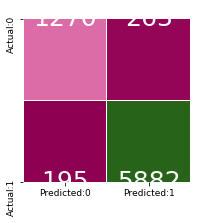

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   

   Misclassfication  
0          6.018397  
*************************************************************************************
Decision Tree :



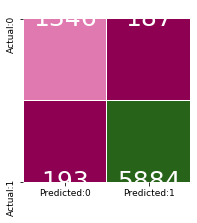

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   

   Misclassfication  
0          6.018397  
1          4.993430  
*************************************************************************************
Random Forest :



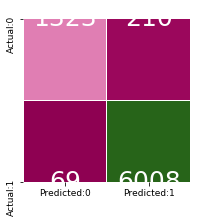

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   
2        Random Forest   0.966227     0.988646              96.333771   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
*************************************************************************************
Ada Boost :



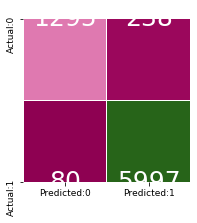

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   
2        Random Forest   0.966227     0.988646              96.333771   
3            Ada Boost   0.961828     0.986836              95.821288   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
3          4.178712  
*************************************************************************************
Gradient Boosting :



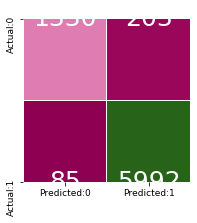

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   
2        Random Forest   0.966227     0.988646              96.333771   
3            Ada Boost   0.961828     0.986836              95.821288   
4    Gradient Boosting   0.967232     0.986013              96.215506   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
3          4.178712  
4          3.784494  
*************************************************************************************
Gaussian NB :



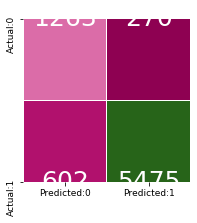

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   
2        Random Forest   0.966227     0.988646              96.333771   
3            Ada Boost   0.961828     0.986836              95.821288   
4    Gradient Boosting   0.967232     0.986013              96.215506   
5          Gaussian NB   0.953003     0.900938              88.541393   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
3          4.178712  
4          3.784494  
5         11.458607  
*************************************************************************************
Bagging Classifier :



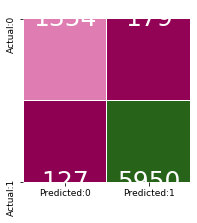

                 Model  Precision  Sensitivity  Correct_classfication  \
0  Logistic Regression   0.957201     0.967912              93.981603   
1        Decision Tree   0.969198     0.968241              95.006570   
2        Random Forest   0.966227     0.988646              96.333771   
3            Ada Boost   0.961828     0.986836              95.821288   
4    Gradient Boosting   0.967232     0.986013              96.215506   
5          Gaussian NB   0.953003     0.900938              88.541393   
6   Bagging Classifier   0.970795     0.979102              95.978975   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
3          4.178712  
4          3.784494  
5         11.458607  
6          4.021025  
*************************************************************************************
Extreme Gradient Boosting :

[19:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


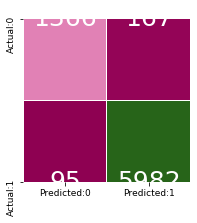

                       Model  Precision  Sensitivity  Correct_classfication  \
0        Logistic Regression   0.957201     0.967912              93.981603   
1              Decision Tree   0.969198     0.968241              95.006570   
2              Random Forest   0.966227     0.988646              96.333771   
3                  Ada Boost   0.961828     0.986836              95.821288   
4          Gradient Boosting   0.967232     0.986013              96.215506   
5                Gaussian NB   0.953003     0.900938              88.541393   
6         Bagging Classifier   0.970795     0.979102              95.978975   
7  Extreme Gradient Boosting   0.972841     0.984367              96.557162   

   Misclassfication  
0          6.018397  
1          4.993430  
2          3.666229  
3          4.178712  
4          3.784494  
5         11.458607  
6          4.021025  
7          3.442838  
*************************************************************************************


In [102]:
print('Logistic Regression :\n')
print(plot_confusion_matrix(LR,'Logistic Regression',X_train,X_test, y_train,y_test))
print('*'*85)

print('Decision Tree :\n')
print(plot_confusion_matrix(DT,'Decision Tree',X_train,X_test, y_train,y_test))
print('*'*85)

print('Random Forest :\n')
print(plot_confusion_matrix(RF,'Random Forest',X_train,X_test, y_train,y_test))
print('*'*85)

# print('KNeighbors :\n')
# print(plot_confusion_matrix(KNN,'KNeighbors',X_train,X_test, y_train,y_test))
# print('*'*85)

print('Ada Boost :\n')
print(plot_confusion_matrix(AB,'Ada Boost',X_train,X_test, y_train,y_test))
print('*'*85)

print('Gradient Boosting :\n')
print(plot_confusion_matrix(GB,'Gradient Boosting',X_train,X_test, y_train,y_test))
print('*'*85)

print('Gaussian NB :\n')
print(plot_confusion_matrix(NB,'Gaussian NB',X_train,X_test, y_train,y_test))
print('*'*85)

print('Bagging Classifier :\n')
print(plot_confusion_matrix(Bag,'Bagging Classifier',X_train,X_test, y_train,y_test))
print('*'*85)

print('Extreme Gradient Boosting :\n')
print(plot_confusion_matrix(Xg,'Extreme Gradient Boosting',X_train,X_test, y_train,y_test))
print('*'*85)

In [103]:
print('Logistic Regression :\n')
print(get_train_report(LR,X_train,y_train))
print(get_test_report(LR,X_test,y_test))
print('*'*85)

print('Decision Tree :\n')
print(get_train_report(DT,X_train,y_train))
print(get_test_report(DT,X_test,y_test))
print('*'*85)

print('Random Forest :\n')
print(get_train_report(RF,X_train,y_train))
print(get_test_report(RF,X_test,y_test))
print('*'*85)

# print('KNeighbors :\n')
# print(get_train_report(KNN,X_train,y_train))
# print(get_test_report(KNN,X_test,y_test))
# print('*'*85)

print('Ada Boost :\n')
print(get_train_report(AB,X_train,y_train))
print(get_test_report(AB,X_test,y_test))
print('*'*85)

print('Gradient Boosting :\n')
print(get_train_report(GB,X_train,y_train))
print(get_test_report(GB,X_test,y_test))
print('*'*85)

print('Gaussian NB :\n')
print(get_train_report(NB,X_train,y_train))
print(get_test_report(NB,X_test,y_test))
print('*'*85)

print('Bagging Classifier :\n')
print(get_train_report(Bag,X_train,y_train))
print(get_test_report(Bag,X_test,y_test))
print('*'*85)

print('Extreme Gradient Boosting :\n')
print(get_train_report(Xg,X_train,y_train))
print(get_test_report(Xg,X_test,y_test))
print('*'*85)

Logistic Regression :


Train report : 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      3575
           1       0.96      0.97      0.97     14180

    accuracy                           0.94     17755
   macro avg       0.92      0.90      0.91     17755
weighted avg       0.94      0.94      0.94     17755


Test report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1533
           1       0.96      0.97      0.96      6077

    accuracy                           0.94      7610
   macro avg       0.91      0.90      0.90      7610
weighted avg       0.94      0.94      0.94      7610

*************************************************************************************
Decision Tree :


Train report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00     14180

   

D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
